# GSM8K pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [29]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root location for evaluation outputs and the metric key to read
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results")
DATASET_KEY = "test_score/openai/gsm8k"

print(f"Base directory: {BASE_DIR}")



Base directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results


In [30]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    - For majority files (samples > 1 or filename contains 'majority'), look for a line
      containing 'Pass@' and take the first float after the colon.
    - Otherwise, look for the last dict line containing the dataset_key.
    """
    if not result_path.exists():
        return None

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        for line in text:
            if "Pass@" in line:
                # Expect formats like: "Pass@32 (Any Correct):            0.6884 (68.84%)"
                parts = line.split(":")
                if len(parts) > 1:
                    try:
                        return float(parts[1].split()[0])
                    except Exception:
                        pass
                # Fallback: grab first float on the line
                import re as _re
                match = _re.search(r"([0-9]*\.?[0-9]+)", line)
                if match:
                    try:
                        return float(match.group(1))
                    except Exception:
                        pass
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return payload[dataset_key]
    return None

# Collect pre-train runs (pattern: 1B-step{step}-{shot}shot-{samples}samples-temp{temp})
pretrain_rows = []
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Collect RL runs from both naming schemes below
#   1) 1B-step{pt_step}-rl-step{rl_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) olmo2_1b_step{pt_step}_omigsm8k-step{rl_step}-rl-0shot-boxed-{samples}samples-temp{temp}
rl_rows = []
rl_patterns = [
    re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# Collect SFT runs
#   1) 1B-step{pt_step}-sft-step{sft_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) OLMo2-1B-step{pt_step}-stage2-openmathgsm8k-step{sft_step}-hf-{shot}shot-{samples}samples-temp{temp}
sft_rows = []
sft_patterns = [
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
]

for path in BASE_DIR.iterdir():
    if not path.is_dir():
        continue
    name = path.name

    # Pre-train collection
    pre_match = pre_pattern.match(name)
    if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
        samples = int(pre_match.group("samples"))
        result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
        score = read_score(path / result_file, samples=samples)
        pretrain_rows.append(
            {
                "step": int(pre_match.group("step")),
                "shot": int(pre_match.group("shot")),
                "samples": samples,
                "temp": float(pre_match.group("temp")),
                "score": score,
                "path": str(path),
            }
        )
        continue

    # RL collection (first pattern that matches wins)
    matched = False
    for pat in rl_patterns:
        rl_match = pat.match(name)
        if rl_match:
            samples = int(rl_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            score = read_score(path / result_file, samples=samples)
            pt_step = int(rl_match.group("pt_step"))
            rl_step = int(rl_match.group("rl_step"))
            rl_rows.append(
                {
                    "pt_step": pt_step,
                    "rl_step": rl_step,
                    "total_step": pt_step + rl_step,
                    "samples": samples,
                    "temp": float(rl_match.group("temp")),
                    "score": score,
                    "path": str(path),
                    "label": name,
                }
            )
            matched = True
            break
    if matched:
        continue

    # SFT collection (first pattern that matches wins)
    for pat in sft_patterns:
        sft_match = pat.match(name)
        if sft_match:
            samples = int(sft_match.group("samples"))
            shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            score = read_score(path / result_file, samples=samples)
            pt_step = int(sft_match.group("pt_step"))
            sft_step = int(sft_match.group("sft_step"))
            sft_rows.append(
                {
                    "pt_step": pt_step,
                    "sft_step": sft_step,
                    "total_step": pt_step + sft_step,
                    "shot": shot,
                    "samples": samples,
                    "temp": float(sft_match.group("temp")),
                    "score": score,
                    "path": str(path),
                    "label": name,
                }
            )
            break

pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")



Loaded 94 pre-train runs, 36 RL runs, 28 SFT runs.


In [31]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp"]))
print()
display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))



,step,shot,samples,temp,score,path
1,1000,1,1,0.0,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,1,8,0.6,0.035600,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,1,32,0.6,0.059100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
0,1000,1,128,0.6,0.123600,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,8,1,0.0,0.015921,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
51,22000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
52,22000,8,8,0.6,0.462500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
49,22000,8,32,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
50,22000,8,32,0.6,0.688400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,score,path,label
21,3000,800,3800,1,0.0,0.046247,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000_omigsm8k-step800-rl-0shot-bo...
23,3000,800,3800,8,0.6,0.078800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000_omigsm8k-step800-rl-0shot-bo...
22,3000,800,3800,32,0.6,0.100100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000_omigsm8k-step800-rl-0shot-bo...
20,3000,800,3800,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step3000_omigsm8k-step800-rl-0shot-bo...
5,5000,650,5650,1,0.0,0.062168,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,1B-step5000-rl-step650-0shot-boxed-1samples-te...
25,5000,800,5800,1,0.0,0.063685,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
27,5000,800,5800,8,0.6,0.091000,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
26,5000,800,5800,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
24,5000,800,5800,128,0.6,0.113000,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step5000_omigsm8k-step800-rl-0shot-bo...
6,6000,650,6650,1,0.0,0.056861,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,1B-step6000-rl-step650-0shot-boxed-1samples-te...


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label
13,3000,285,3285,0,1,0.0,0.122820,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...
15,3000,285,3285,0,8,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...
14,3000,285,3285,0,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...
12,3000,285,3285,0,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...
17,5000,285,5285,0,1,0.0,0.197119,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-step285...
19,5000,285,5285,0,8,0.6,0.473100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-step285...
18,5000,285,5285,0,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-step285...
16,5000,285,5285,0,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step5000-stage2-openmathgsm8k-step285...
21,6000,285,6285,0,1,0.0,0.250190,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step6000-stage2-openmathgsm8k-step285...
23,6000,285,6285,0,8,0.6,0.514800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step6000-stage2-openmathgsm8k-step285...


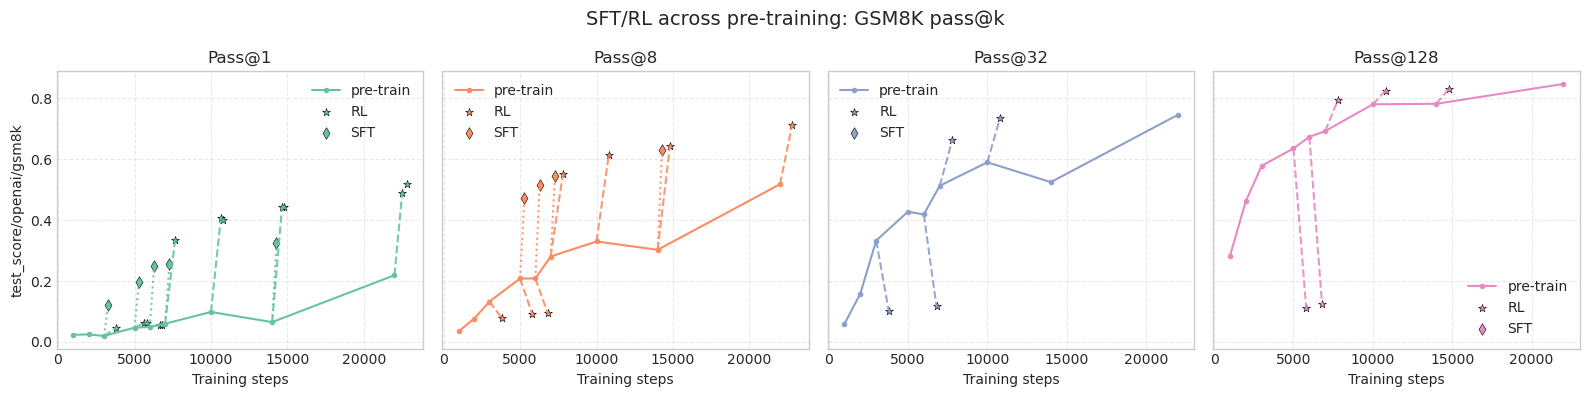

In [32]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32, 128]
BASE_PRETRAIN_SHOT = 1
SHOT_BY_SAMPLES = lambda s: 8 if s == 128 else BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.0 if s == 1 else 0.6

available_samples = sorted(set(pre_df["samples"]).union(rl_df["samples"]).union(sft_df["samples"]))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n = len(plot_samples)
    ncols = n  # 2 if n > 1 else 1
    nrows = 1  # (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]
    cmap = plt.get_cmap("Set2")

    for idx, samples in enumerate(plot_samples):
        ax = axes[idx]
        target_temp = TEMP_BY_SAMPLES(samples)
        shot = SHOT_BY_SAMPLES(samples)
        color = cmap(idx % cmap.N)

        pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
        if not pre_curve.empty:
            ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")

        # RL
        rl_curve = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == target_temp)].sort_values(["pt_step", "rl_step"])
        rl_labeled = False
        for pt_step, group in rl_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("rl_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="*", color=color, s=35, edgecolor="k", linewidth=0.4, label="RL" if not rl_labeled else None)
                rl_labeled = True

        # SFT
        sft_curve = sft_df[(sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft_labeled = False
        for pt_step, group in sft_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            ax.plot(xs, ys, linestyle=":", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT" if not sft_labeled else None)
                sft_labeled = True

        ax.set_title(f"Pass@{samples}")
        ax.set_xlabel("Training steps")
        if idx % ncols == 0:
            ax.set_ylabel(DATASET_KEY)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend()

    fig.suptitle(f"SFT/RL across pre-training: GSM8K pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()



In [37]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist())
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
        row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None

        sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
        if not sft_slice.empty:
            best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
            row[f"sft_p{k}"] = best_sft["score"]
            # row[f"sft_step{k}"] = best_sft["total_step"]
        else:
            row[f"sft_p{k}"] = None
            # row[f"sft_step{k}"] = None

        rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
        if not rl_slice.empty:
            best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
            row[f"rl_p{k}"] = best_rl["score"]
            # row[f"rl_step{k}"] = best_rl["total_step"]
        else:
            row[f"rl_p{k}"] = None
            # row[f"rl_step{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True)
concise_df



,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.023503,NaN,NaN,0.0356,NaN,NaN,0.0591,NaN,NaN,0.2828,NaN,NaN
1,2000,0.025019,NaN,NaN,0.0766,NaN,NaN,0.1585,NaN,NaN,0.4625,NaN,NaN
2,3000,0.019712,0.122820,0.046247,0.1327,NaN,0.0788,0.3328,NaN,0.1001,0.5785,NaN,NaN
3,5000,0.047005,0.197119,0.063685,0.2085,0.4731,0.0910,0.4276,NaN,NaN,0.6353,NaN,0.1130
4,6000,0.049280,0.250190,0.056103,0.2085,0.5148,0.0963,0.4185,NaN,0.1168,0.6732,NaN,0.1243
5,7000,0.059894,0.257013,NaN,0.2805,0.5444,0.5497,0.5125,NaN,0.6634,0.6922,NaN,0.7945
6,10000,0.098560,NaN,0.401061,0.3298,NaN,0.6133,0.5898,NaN,0.7354,0.7801,NaN,0.8249
7,14000,0.065201,0.324488,0.443518,0.3025,0.6293,0.6422,0.5246,NaN,NaN,0.7817,NaN,0.8317
8,22000,0.219105,NaN,0.518575,0.5178,NaN,0.7134,0.7453,NaN,NaN,0.8469,NaN,NaN
